In [1]:
import numpy as np
from numba import njit,jit
import matplotlib.pyplot as plt
from tqdm import tqdm

# 设定参数

## 基本参数

In [2]:
num_electron = 2*10**(5)
num_Hg = 7
num_voltage = 500
max_voltage = 40
lambda_Ek = 1.5
negative_voltage = 2.4
acc_voltage = 1

# 设定常量

## 激发常量

In [3]:
E_state = np.array([4.67,4.89,5.46,6.7])
p1 = 0.5
p2 = 0.6
p3 = 0.7

In [4]:
p01 = 0.4
p02 = 0.4
excite_2 = np.array([p01,p1+p01,p2+p1+p01])/(p01+p1+p2)
excite_3 = np.array([p02,p1+p02,p3+p1+p02,p3+p3+p1+p02])/(p02+p1+p3+p3)
excite_4 = np.array([0.1,0.3,0.5,0.7,1.0])

# 初始化参数

## 初始化动能

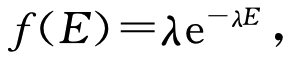

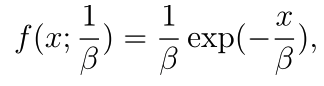

In [5]:
Ek = np.random.exponential(1/lambda_Ek,(num_voltage,num_electron))

## 生成Hg原子相对位置

In [6]:
Hg_pos = np.random.uniform(0,1,num_Hg)
Hg_pos = np.sort(Hg_pos)

## 确定每级加速能量

### 预加速能量

In [7]:
voltage_arr = np.arange(0,max_voltage,max_voltage/num_voltage)

### 加速管能量

In [8]:
accelerate_tem = np.concatenate([Hg_pos,np.array([1])])-np.concatenate([np.array([0]),Hg_pos])

accelerate_start = accelerate_tem[0]
E_start = accelerate_start*acc_voltage

accelerate_arr = accelerate_tem[1:]
E_accelerate = accelerate_arr*acc_voltage

# 核心函数

## 确定所处位置

In [9]:
@njit
def locate(x,arr):
    return np.sum(np.expand_dims(x,axis = -1)-arr>0,axis = -1)

## 激发

In [10]:
@njit
def my_and(tup):
    return np.sum(np.stack(tup,axis = -1),axis = -1)==2

In [11]:
def excite(Ek,E_state,p1,excite_2,excite_3,excite_4):
    delta_E = np.zeros(Ek.shape) # 能量差
    p = np.random.uniform(0,1,Ek.shape) # 概率
    pos = locate(Ek,E_state) # 定位
    
    # 第一激发态
    delta_E[my_and((pos==1,p<p1))] = E_state[0]
    
    # 第二激发态
    pos_2 = locate(p,excite_2)
    delta_E[my_and((pos==2,pos_2==1))] = E_state[0]
    delta_E[my_and((pos==2,pos_2==2))] = E_state[1]
    
    
    # 第三激发态
    pos_3 = locate(p,excite_3)
    delta_E[my_and((pos==3,pos_3==1))] = E_state[0]
    delta_E[my_and((pos==3,pos_3==2))] = E_state[1]
    delta_E[my_and((pos==3,pos_3==3))] = E_state[2]
    
    # 第四激发态
    pos_4 = locate(p,excite_4)
    delta_E[my_and((pos==4,pos_4==1))] = E_state[0]
    delta_E[my_and((pos==4,pos_4==2))] = E_state[1]
    delta_E[my_and((pos==4,pos_4==3))] = E_state[2]
    delta_E[my_and((pos==4,pos_4==4))] = E_state[3]
    
    
    return Ek - delta_E

# 通过管道

In [12]:
Ek += voltage_arr[...,None] #预加速
Ek += E_start

In [13]:
for i in tqdm(range(num_Hg)):
    Ek = excite(Ek,E_state,p1,excite_2,excite_3,excite_4)
    Ek += E_accelerate[i][...,None]   

100%|██████████| 7/7 [02:30<00:00, 21.55s/it]


# 被吸收

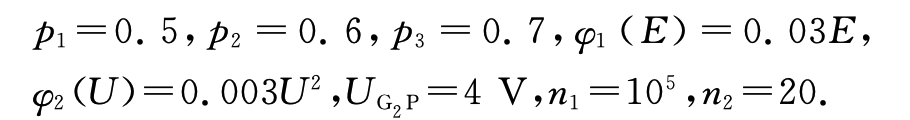

In [14]:
possibility = np.exp(-0.03*Ek-0.003*(acc_voltage**2))
p = np.random.uniform(0,1,Ek.shape)

In [15]:
Ek[p<possibility] = -np.inf

# 通过反向电压

In [16]:
Ek -= negative_voltage

In [17]:
I = np.sum(Ek>0,axis=-1)/num_electron

In [18]:
print(np.stack((voltage_arr,I),axis = -1))

[[0.00000e+00 1.06100e-02]
 [8.00000e-02 1.18950e-02]
 [1.60000e-01 1.39050e-02]
 [2.40000e-01 1.52700e-02]
 [3.20000e-01 1.72150e-02]
 [4.00000e-01 1.91150e-02]
 [4.80000e-01 2.22400e-02]
 [5.60000e-01 2.45200e-02]
 [6.40000e-01 2.78500e-02]
 [7.20000e-01 3.11950e-02]
 [8.00000e-01 3.59050e-02]
 [8.80000e-01 4.07350e-02]
 [9.60000e-01 4.52700e-02]
 [1.04000e+00 5.01150e-02]
 [1.12000e+00 5.72650e-02]
 [1.20000e+00 6.47350e-02]
 [1.28000e+00 7.23800e-02]
 [1.36000e+00 8.14900e-02]
 [1.44000e+00 8.80400e-02]
 [1.52000e+00 8.96950e-02]
 [1.60000e+00 9.20850e-02]
 [1.68000e+00 9.29450e-02]
 [1.76000e+00 9.42050e-02]
 [1.84000e+00 9.74850e-02]
 [1.92000e+00 9.83500e-02]
 [2.00000e+00 9.86550e-02]
 [2.08000e+00 9.94700e-02]
 [2.16000e+00 1.01760e-01]
 [2.24000e+00 1.01515e-01]
 [2.32000e+00 1.03185e-01]
 [2.40000e+00 1.03655e-01]
 [2.48000e+00 1.04665e-01]
 [2.56000e+00 1.05460e-01]
 [2.64000e+00 1.04930e-01]
 [2.72000e+00 1.04455e-01]
 [2.80000e+00 1.03750e-01]
 [2.88000e+00 1.03020e-01]
 

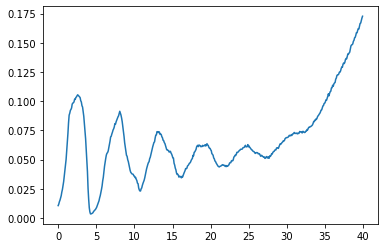

In [19]:
plt.plot(voltage_arr,I)
plt.show()